In [25]:
import numpy as np
import sys
import os
import torch
import wandb

import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchinfo import summary

import matplotlib.pyplot as plt

# Define the path to the parent project folder
project_path = r'C:/Users/palig/MSE/Vertiefungsprojekt1/mse_vp1_rulestimation'

# Add the path to sys.path if it does not already exist
if project_path not in sys.path:
    sys.path.append(project_path)

from torch import optim as optim
from torch.utils.data import DataLoader, random_split

from models.pinn import PINN, PhysicsBasedLoss, AdaptivePhysicsBasedLoss, Adan, Score
from utils.preprocess_pinn import CMAPSSDataset
from utils.train_pinn import Trainer, test_model

# Configure device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# normalization

data_path = os.path.join(project_path, 'data', 'final')
save_path = os.path.join(project_path, 'models', 'trained_models')
model_path = os.path.join(project_path, 'models')
result_path = os.path.join(project_path, 'data', 'results')

model_results = {}

In [26]:
api = wandb.Api()

project_name = "mse-vp1"
entity = "p-alig-fh-ost"

config = {
    "learning_rate": 1e-3,
    "num_epochs": 400,
    "batch_size": 128,
    "derivatives_order": 2,
    "hidden_dim": 3,
    "loss_lambda": 100,
    "dataset": "13",
    "model": "PINN_13"
}

Load data from group 1 (DF1 and DF3)

In [3]:
ds_train = CMAPSSDataset(mode='train', data_path=data_path, subset=config["dataset"], max_rul=125)

total_size = len(ds_train)

val_size = int(0.2 * total_size)  # 20% für Validierung
train_size = total_size - val_size  # Rest für Training
train_ds, val_ds = random_split(ds_train, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False, num_workers=0)

# Warm up (can take a while!)
for batch in train_loader:
    print(batch[2].shape)
    print("Warmed up")
    break

Found 200 unique motor IDs in the data set.
(45351, 16)
torch.Size([128])
Warmed up


In [27]:
model = PINN(input_dim=14, hidden_dim=config["hidden_dim"], derivatives_order=config["derivatives_order"]).to(device)
optimizer = Adan(model.parameters(), lr=config["learning_rate"])
criterion = AdaptivePhysicsBasedLoss(loss_lambda=config["loss_lambda"])
summary(model)

Layer (type:depth-idx)                                  Param #
PINN                                                    --
├─xNN: 1-1                                              --
│    └─MultiheadAttention: 2-1                          630
│    │    └─NonDynamicallyQuantizableLinear: 3-1        210
│    └─Linear: 2-2                                      210
│    └─Linear: 2-3                                      45
│    └─LayerNorm: 2-4                                   28
│    └─ReLU: 2-5                                        --
├─MLP: 1-2                                              6
│    └─Sequential: 2-6                                  --
│    │    └─Linear: 3-2                                 50
│    │    └─Tanh: 3-3                                   --
│    │    └─Linear: 3-4                                 110
│    │    └─Tanh: 3-5                                   --
│    │    └─Linear: 3-6                                 110
│    │    └─Tanh: 3-7                          

In [5]:
run = wandb.init(
    project=project_name,
    name=f'PINN_{config["dataset"]}',
    config = config
)

wandb: Currently logged in as: p-alig (p-alig-fh-ost). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Training of group 1 (DF1 and DF3)

In [6]:
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, config)
trainer.fit()
torch.save(model.state_dict(), os.path.join(save_path, f'{run.config["model"]}_best.pth'))
run.finish()

Epoch 1/400


Validation Epoch 1: 100%|██████████| 71/71 [00:09<00:00,  7.13it/s]


Epoch 2/400


Validation Epoch 2: 100%|██████████| 71/71 [00:10<00:00,  6.75it/s]


Epoch 3/400


Validation Epoch 3: 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


Epoch 4/400


Validation Epoch 4: 100%|██████████| 71/71 [00:11<00:00,  6.24it/s]


Epoch 5/400


Validation Epoch 5: 100%|██████████| 71/71 [00:11<00:00,  6.25it/s]


Epoch 6/400


Validation Epoch 6: 100%|██████████| 71/71 [00:11<00:00,  6.44it/s]


Epoch 7/400


Validation Epoch 7: 100%|██████████| 71/71 [00:11<00:00,  6.36it/s]


Epoch 8/400


Validation Epoch 8: 100%|██████████| 71/71 [00:11<00:00,  6.45it/s]


Epoch 9/400


Validation Epoch 9: 100%|██████████| 71/71 [00:10<00:00,  6.52it/s]


Epoch 10/400


Validation Epoch 10: 100%|██████████| 71/71 [00:10<00:00,  6.51it/s]


Epoch 11/400


Validation Epoch 11: 100%|██████████| 71/71 [00:10<00:00,  6.60it/s]


Epoch 12/400


Validation Epoch 12: 100%|██████████| 71/71 [00:11<00:00,  6.45it/s]


Epoch 13/400


Validation Epoch 13: 100%|██████████| 71/71 [00:10<00:00,  6.67it/s]


Epoch 14/400


Validation Epoch 14: 100%|██████████| 71/71 [00:10<00:00,  6.47it/s]


Epoch 15/400


Validation Epoch 15: 100%|██████████| 71/71 [00:10<00:00,  6.48it/s]


Epoch 16/400


Validation Epoch 16: 100%|██████████| 71/71 [00:11<00:00,  6.42it/s]


Epoch 17/400


Validation Epoch 17: 100%|██████████| 71/71 [00:11<00:00,  6.40it/s]


Epoch 18/400


Validation Epoch 18: 100%|██████████| 71/71 [00:11<00:00,  6.44it/s]


Epoch 19/400


Validation Epoch 19: 100%|██████████| 71/71 [00:10<00:00,  6.69it/s]


Epoch 20/400


Validation Epoch 20: 100%|██████████| 71/71 [00:10<00:00,  6.62it/s]


Epoch 21/400


Validation Epoch 21: 100%|██████████| 71/71 [00:11<00:00,  6.41it/s]


Epoch 22/400


Validation Epoch 22: 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


Epoch 23/400


Validation Epoch 23: 100%|██████████| 71/71 [00:10<00:00,  6.54it/s]


Epoch 24/400


Validation Epoch 24: 100%|██████████| 71/71 [00:11<00:00,  6.32it/s]


Epoch 25/400


Validation Epoch 25: 100%|██████████| 71/71 [00:10<00:00,  6.70it/s]


Epoch 26/400


Validation Epoch 26: 100%|██████████| 71/71 [00:10<00:00,  6.49it/s]


Epoch 27/400


Validation Epoch 27: 100%|██████████| 71/71 [00:11<00:00,  6.28it/s]


Epoch 28/400


Validation Epoch 28: 100%|██████████| 71/71 [00:10<00:00,  6.76it/s]


Epoch 29/400


Validation Epoch 29: 100%|██████████| 71/71 [00:10<00:00,  6.58it/s]


Epoch 30/400


Validation Epoch 30: 100%|██████████| 71/71 [00:10<00:00,  6.54it/s]


Epoch 31/400


Validation Epoch 31: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


Epoch 32/400


Validation Epoch 32: 100%|██████████| 71/71 [00:10<00:00,  6.58it/s]


Epoch 33/400


Validation Epoch 33: 100%|██████████| 71/71 [00:10<00:00,  6.91it/s]


Epoch 34/400


Validation Epoch 34: 100%|██████████| 71/71 [00:11<00:00,  6.25it/s]


Epoch 35/400


Validation Epoch 35: 100%|██████████| 71/71 [00:11<00:00,  6.45it/s]


Epoch 36/400


Validation Epoch 36: 100%|██████████| 71/71 [00:10<00:00,  6.54it/s]


Epoch 37/400


Validation Epoch 37: 100%|██████████| 71/71 [00:10<00:00,  6.55it/s]


Epoch 38/400


Validation Epoch 38: 100%|██████████| 71/71 [00:10<00:00,  6.53it/s]


Epoch 39/400


Validation Epoch 39: 100%|██████████| 71/71 [00:10<00:00,  6.46it/s]


Epoch 40/400


Validation Epoch 40: 100%|██████████| 71/71 [00:10<00:00,  6.47it/s]


Epoch 41/400


Validation Epoch 41: 100%|██████████| 71/71 [00:10<00:00,  6.58it/s]


Epoch 42/400


Validation Epoch 42: 100%|██████████| 71/71 [00:10<00:00,  6.57it/s]


Epoch 43/400


Validation Epoch 43: 100%|██████████| 71/71 [00:10<00:00,  6.55it/s]


Epoch 44/400


Validation Epoch 44: 100%|██████████| 71/71 [00:10<00:00,  6.58it/s]


Epoch 45/400


Validation Epoch 45: 100%|██████████| 71/71 [00:11<00:00,  6.41it/s]


Epoch 46/400


Validation Epoch 46: 100%|██████████| 71/71 [00:10<00:00,  6.56it/s]


Epoch 47/400


Validation Epoch 47: 100%|██████████| 71/71 [00:10<00:00,  6.65it/s]


Epoch 48/400


Validation Epoch 48: 100%|██████████| 71/71 [00:10<00:00,  6.51it/s]


Epoch 49/400


Validation Epoch 49: 100%|██████████| 71/71 [00:10<00:00,  6.52it/s]


Epoch 50/400


Validation Epoch 50: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


Epoch 51/400


Validation Epoch 51: 100%|██████████| 71/71 [00:11<00:00,  6.22it/s]


Epoch 52/400


Validation Epoch 52: 100%|██████████| 71/71 [00:10<00:00,  6.61it/s]


Epoch 53/400


Validation Epoch 53: 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


Epoch 54/400


Validation Epoch 54: 100%|██████████| 71/71 [00:11<00:00,  6.34it/s]


Epoch 55/400


Validation Epoch 55: 100%|██████████| 71/71 [00:10<00:00,  6.46it/s]


Epoch 56/400


Validation Epoch 56: 100%|██████████| 71/71 [00:11<00:00,  6.34it/s]


Epoch 57/400


Validation Epoch 57: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


Epoch 58/400


Validation Epoch 58: 100%|██████████| 71/71 [00:11<00:00,  6.26it/s]


Epoch 59/400


Validation Epoch 59: 100%|██████████| 71/71 [00:11<00:00,  6.26it/s]


Epoch 60/400


Validation Epoch 60: 100%|██████████| 71/71 [00:11<00:00,  6.25it/s]


Epoch 61/400


Validation Epoch 61: 100%|██████████| 71/71 [00:12<00:00,  5.89it/s]


Epoch 62/400


Validation Epoch 62: 100%|██████████| 71/71 [00:11<00:00,  6.05it/s]


Epoch 63/400


Validation Epoch 63: 100%|██████████| 71/71 [00:11<00:00,  6.04it/s]


Epoch 64/400


Validation Epoch 64: 100%|██████████| 71/71 [00:11<00:00,  6.23it/s]


Epoch 65/400


Validation Epoch 65: 100%|██████████| 71/71 [00:11<00:00,  6.12it/s]


Epoch 66/400


Validation Epoch 66: 100%|██████████| 71/71 [00:11<00:00,  6.16it/s]


Epoch 67/400


Validation Epoch 67: 100%|██████████| 71/71 [00:11<00:00,  6.19it/s]


Epoch 68/400


Validation Epoch 68: 100%|██████████| 71/71 [00:11<00:00,  6.17it/s]


Epoch 69/400


Validation Epoch 69: 100%|██████████| 71/71 [00:11<00:00,  6.18it/s]


Epoch 70/400


Validation Epoch 70: 100%|██████████| 71/71 [00:11<00:00,  6.37it/s]


Epoch 71/400


Validation Epoch 71: 100%|██████████| 71/71 [00:10<00:00,  6.54it/s]


Epoch 72/400


Validation Epoch 72: 100%|██████████| 71/71 [00:10<00:00,  6.81it/s]


Epoch 73/400


Validation Epoch 73: 100%|██████████| 71/71 [00:10<00:00,  6.84it/s]


Epoch 74/400


Validation Epoch 74: 100%|██████████| 71/71 [00:10<00:00,  6.81it/s]


Epoch 75/400


Validation Epoch 75: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


Epoch 76/400


Validation Epoch 76: 100%|██████████| 71/71 [00:10<00:00,  6.92it/s]


Epoch 77/400


Validation Epoch 77: 100%|██████████| 71/71 [00:09<00:00,  7.16it/s]


Epoch 78/400


Validation Epoch 78: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 79/400


Validation Epoch 79: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 80/400


Validation Epoch 80: 100%|██████████| 71/71 [00:10<00:00,  6.87it/s]


Epoch 81/400


Validation Epoch 81: 100%|██████████| 71/71 [00:10<00:00,  7.09it/s]


Epoch 82/400


Validation Epoch 82: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 83/400


Validation Epoch 83: 100%|██████████| 71/71 [00:10<00:00,  6.73it/s]


Epoch 84/400


Validation Epoch 84: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 85/400


Validation Epoch 85: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


Epoch 86/400


Validation Epoch 86: 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 87/400


Validation Epoch 87: 100%|██████████| 71/71 [00:10<00:00,  6.91it/s]


Epoch 88/400


Validation Epoch 88: 100%|██████████| 71/71 [00:10<00:00,  6.87it/s]


Epoch 89/400


Validation Epoch 89: 100%|██████████| 71/71 [00:10<00:00,  6.91it/s]


Epoch 90/400


Validation Epoch 90: 100%|██████████| 71/71 [00:10<00:00,  7.00it/s]


Epoch 91/400


Validation Epoch 91: 100%|██████████| 71/71 [00:10<00:00,  6.76it/s]


Epoch 92/400


Validation Epoch 92: 100%|██████████| 71/71 [00:10<00:00,  6.96it/s]


Epoch 93/400


Validation Epoch 93: 100%|██████████| 71/71 [00:10<00:00,  6.92it/s]


Epoch 94/400


Validation Epoch 94: 100%|██████████| 71/71 [00:10<00:00,  6.75it/s]


Epoch 95/400


Validation Epoch 95: 100%|██████████| 71/71 [00:10<00:00,  6.92it/s]


Epoch 96/400


Validation Epoch 96: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


Epoch 97/400


Validation Epoch 97: 100%|██████████| 71/71 [00:10<00:00,  6.83it/s]


Epoch 98/400


Validation Epoch 98: 100%|██████████| 71/71 [00:10<00:00,  6.65it/s]


Epoch 99/400


Validation Epoch 99: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 100/400


Validation Epoch 100: 100%|██████████| 71/71 [00:10<00:00,  6.84it/s]


Epoch 101/400


Validation Epoch 101: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 102/400


Validation Epoch 102: 100%|██████████| 71/71 [00:10<00:00,  6.97it/s]


Epoch 103/400


Validation Epoch 103: 100%|██████████| 71/71 [00:10<00:00,  6.76it/s]


Epoch 104/400


Validation Epoch 104: 100%|██████████| 71/71 [00:10<00:00,  7.04it/s]


Epoch 105/400


Validation Epoch 105: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


Epoch 106/400


Validation Epoch 106: 100%|██████████| 71/71 [00:09<00:00,  7.19it/s]


Epoch 107/400


Validation Epoch 107: 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 108/400


Validation Epoch 108: 100%|██████████| 71/71 [00:10<00:00,  6.62it/s]


Epoch 109/400


Validation Epoch 109: 100%|██████████| 71/71 [00:10<00:00,  7.06it/s]


Epoch 110/400


Validation Epoch 110: 100%|██████████| 71/71 [00:10<00:00,  6.83it/s]


Epoch 111/400


Validation Epoch 111: 100%|██████████| 71/71 [00:09<00:00,  7.12it/s]


Epoch 112/400


Validation Epoch 112: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


Epoch 113/400


Validation Epoch 113: 100%|██████████| 71/71 [00:10<00:00,  6.85it/s]


Epoch 114/400


Validation Epoch 114: 100%|██████████| 71/71 [00:10<00:00,  6.91it/s]


Epoch 115/400


Validation Epoch 115: 100%|██████████| 71/71 [00:10<00:00,  6.75it/s]


Epoch 116/400


Validation Epoch 116: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


Epoch 117/400


Validation Epoch 117: 100%|██████████| 71/71 [00:10<00:00,  6.96it/s]


Epoch 118/400


Validation Epoch 118: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 119/400


Validation Epoch 119: 100%|██████████| 71/71 [00:10<00:00,  6.89it/s]


Epoch 120/400


Validation Epoch 120: 100%|██████████| 71/71 [00:10<00:00,  6.94it/s]


Epoch 121/400


Validation Epoch 121: 100%|██████████| 71/71 [00:10<00:00,  6.84it/s]


Epoch 122/400


Validation Epoch 122: 100%|██████████| 71/71 [00:10<00:00,  6.98it/s]


Epoch 123/400


Validation Epoch 123: 100%|██████████| 71/71 [00:10<00:00,  6.91it/s]


Epoch 124/400


Validation Epoch 124: 100%|██████████| 71/71 [00:10<00:00,  7.05it/s]


Epoch 125/400


Validation Epoch 125: 100%|██████████| 71/71 [00:10<00:00,  6.81it/s]


Epoch 126/400


Validation Epoch 126: 100%|██████████| 71/71 [00:10<00:00,  6.85it/s]


Epoch 127/400


Validation Epoch 127: 100%|██████████| 71/71 [00:10<00:00,  6.77it/s]


Epoch 128/400


Validation Epoch 128: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


Epoch 129/400


Validation Epoch 129: 100%|██████████| 71/71 [00:10<00:00,  6.84it/s]


Epoch 130/400


Validation Epoch 130: 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 131/400


Validation Epoch 131: 100%|██████████| 71/71 [00:10<00:00,  6.83it/s]


Epoch 132/400


Validation Epoch 132: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 133/400


Validation Epoch 133: 100%|██████████| 71/71 [00:10<00:00,  6.95it/s]


Epoch 134/400


Validation Epoch 134: 100%|██████████| 71/71 [00:10<00:00,  6.92it/s]


Epoch 135/400


Validation Epoch 135: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


Epoch 136/400


Validation Epoch 136: 100%|██████████| 71/71 [00:10<00:00,  6.76it/s]


Epoch 137/400


Validation Epoch 137: 100%|██████████| 71/71 [00:10<00:00,  6.57it/s]


Epoch 138/400


Validation Epoch 138: 100%|██████████| 71/71 [00:10<00:00,  6.75it/s]


Epoch 139/400


Validation Epoch 139: 100%|██████████| 71/71 [00:10<00:00,  6.87it/s]


Epoch 140/400


Validation Epoch 140: 100%|██████████| 71/71 [00:10<00:00,  7.01it/s]


Epoch 141/400


Validation Epoch 141: 100%|██████████| 71/71 [00:10<00:00,  6.77it/s]


Epoch 142/400


Validation Epoch 142: 100%|██████████| 71/71 [00:10<00:00,  6.91it/s]


Epoch 143/400


Validation Epoch 143: 100%|██████████| 71/71 [00:10<00:00,  6.80it/s]


Epoch 144/400


Validation Epoch 144: 100%|██████████| 71/71 [00:10<00:00,  6.99it/s]


Epoch 145/400


Validation Epoch 145: 100%|██████████| 71/71 [00:10<00:00,  6.79it/s]


Epoch 146/400


Validation Epoch 146: 100%|██████████| 71/71 [00:10<00:00,  7.06it/s]


Epoch 147/400


Validation Epoch 147: 100%|██████████| 71/71 [00:10<00:00,  6.65it/s]


Epoch 148/400


Validation Epoch 148: 100%|██████████| 71/71 [00:10<00:00,  6.85it/s]


Epoch 149/400


Validation Epoch 149: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 150/400


Validation Epoch 150: 100%|██████████| 71/71 [00:10<00:00,  7.05it/s]


Epoch 151/400


Validation Epoch 151: 100%|██████████| 71/71 [00:10<00:00,  7.03it/s]


Epoch 152/400


Validation Epoch 152: 100%|██████████| 71/71 [00:10<00:00,  6.96it/s]


Epoch 153/400


Validation Epoch 153: 100%|██████████| 71/71 [00:10<00:00,  6.84it/s]


Epoch 154/400


Validation Epoch 154: 100%|██████████| 71/71 [00:10<00:00,  7.00it/s]


Epoch 155/400


Validation Epoch 155: 100%|██████████| 71/71 [00:09<00:00,  7.19it/s]


Epoch 156/400


Validation Epoch 156: 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 157/400


Validation Epoch 157: 100%|██████████| 71/71 [00:10<00:00,  6.92it/s]


Epoch 158/400


Validation Epoch 158: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


Epoch 159/400


Validation Epoch 159: 100%|██████████| 71/71 [00:10<00:00,  6.75it/s]


Epoch 160/400


Validation Epoch 160: 100%|██████████| 71/71 [00:10<00:00,  6.79it/s]


Epoch 161/400


Validation Epoch 161: 100%|██████████| 71/71 [00:10<00:00,  6.89it/s]


Epoch 162/400


Validation Epoch 162: 100%|██████████| 71/71 [00:10<00:00,  7.02it/s]


Epoch 163/400


Validation Epoch 163: 100%|██████████| 71/71 [00:10<00:00,  6.77it/s]


Epoch 164/400


Validation Epoch 164: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


Epoch 165/400


Validation Epoch 165: 100%|██████████| 71/71 [00:10<00:00,  7.01it/s]


Epoch 166/400


Validation Epoch 166: 100%|██████████| 71/71 [00:10<00:00,  6.66it/s]


Epoch 167/400


Validation Epoch 167: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 168/400


Validation Epoch 168: 100%|██████████| 71/71 [00:10<00:00,  6.74it/s]


Epoch 169/400


Validation Epoch 169: 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 170/400


Validation Epoch 170: 100%|██████████| 71/71 [00:10<00:00,  6.97it/s]


Epoch 171/400


Validation Epoch 171: 100%|██████████| 71/71 [00:10<00:00,  6.77it/s]


Epoch 172/400


Validation Epoch 172: 100%|██████████| 71/71 [00:10<00:00,  7.03it/s]


Epoch 173/400


Validation Epoch 173: 100%|██████████| 71/71 [00:10<00:00,  6.87it/s]


Epoch 174/400


Validation Epoch 174: 100%|██████████| 71/71 [00:10<00:00,  6.81it/s]


Epoch 175/400


Validation Epoch 175: 100%|██████████| 71/71 [00:10<00:00,  6.70it/s]


Epoch 176/400


Validation Epoch 176: 100%|██████████| 71/71 [00:10<00:00,  6.85it/s]


Epoch 177/400


Validation Epoch 177: 100%|██████████| 71/71 [00:10<00:00,  6.76it/s]


Epoch 178/400


Validation Epoch 178: 100%|██████████| 71/71 [00:10<00:00,  7.05it/s]


Epoch 179/400


Validation Epoch 179: 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 180/400


Validation Epoch 180: 100%|██████████| 71/71 [00:10<00:00,  6.87it/s]


Epoch 181/400


Validation Epoch 181: 100%|██████████| 71/71 [00:10<00:00,  6.95it/s]


Epoch 182/400


Validation Epoch 182: 100%|██████████| 71/71 [00:10<00:00,  6.94it/s]


Epoch 183/400


Validation Epoch 183: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 184/400


Validation Epoch 184: 100%|██████████| 71/71 [00:10<00:00,  7.04it/s]


Epoch 185/400


Validation Epoch 185: 100%|██████████| 71/71 [00:10<00:00,  6.74it/s]


Epoch 186/400


Validation Epoch 186: 100%|██████████| 71/71 [00:10<00:00,  6.97it/s]


Epoch 187/400


Validation Epoch 187: 100%|██████████| 71/71 [00:10<00:00,  7.05it/s]


Epoch 188/400


Validation Epoch 188: 100%|██████████| 71/71 [00:10<00:00,  6.91it/s]


Epoch 189/400


Validation Epoch 189: 100%|██████████| 71/71 [00:10<00:00,  6.94it/s]


Epoch 190/400


Validation Epoch 190: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 191/400


Validation Epoch 191: 100%|██████████| 71/71 [00:10<00:00,  6.79it/s]


Epoch 192/400


Validation Epoch 192: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 193/400


Validation Epoch 193: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 194/400


Validation Epoch 194: 100%|██████████| 71/71 [00:10<00:00,  6.56it/s]


Epoch 195/400


Validation Epoch 195: 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 196/400


Validation Epoch 196: 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 197/400


Validation Epoch 197: 100%|██████████| 71/71 [00:10<00:00,  6.83it/s]


Epoch 198/400


Validation Epoch 198: 100%|██████████| 71/71 [00:10<00:00,  6.80it/s]


Epoch 199/400


Validation Epoch 199: 100%|██████████| 71/71 [00:10<00:00,  6.91it/s]


Epoch 200/400


Validation Epoch 200: 100%|██████████| 71/71 [00:10<00:00,  6.96it/s]


Epoch 201/400


Validation Epoch 201: 100%|██████████| 71/71 [00:10<00:00,  6.84it/s]


Epoch 202/400


Validation Epoch 202: 100%|██████████| 71/71 [00:10<00:00,  6.71it/s]


Epoch 203/400


Validation Epoch 203: 100%|██████████| 71/71 [00:10<00:00,  6.65it/s]


Epoch 204/400


Validation Epoch 204: 100%|██████████| 71/71 [00:10<00:00,  6.85it/s]


Epoch 205/400


Validation Epoch 205: 100%|██████████| 71/71 [00:10<00:00,  7.01it/s]


Epoch 206/400


Validation Epoch 206: 100%|██████████| 71/71 [00:10<00:00,  7.08it/s]


Epoch 207/400


Validation Epoch 207: 100%|██████████| 71/71 [00:10<00:00,  6.77it/s]


Epoch 208/400


Validation Epoch 208: 100%|██████████| 71/71 [00:10<00:00,  6.74it/s]


Epoch 209/400


Validation Epoch 209: 100%|██████████| 71/71 [00:10<00:00,  6.72it/s]


Epoch 210/400


Validation Epoch 210: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


Epoch 211/400


Validation Epoch 211: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


Epoch 212/400


Validation Epoch 212: 100%|██████████| 71/71 [00:10<00:00,  6.98it/s]


Epoch 213/400


Validation Epoch 213: 100%|██████████| 71/71 [00:10<00:00,  6.67it/s]


Epoch 214/400


Validation Epoch 214: 100%|██████████| 71/71 [00:10<00:00,  6.81it/s]


Epoch 215/400


Validation Epoch 215: 100%|██████████| 71/71 [00:10<00:00,  6.92it/s]


Epoch 216/400


Validation Epoch 216: 100%|██████████| 71/71 [00:10<00:00,  6.85it/s]


Epoch 217/400


Validation Epoch 217: 100%|██████████| 71/71 [00:10<00:00,  6.83it/s]


Epoch 218/400


Validation Epoch 218: 100%|██████████| 71/71 [00:10<00:00,  6.99it/s]


Epoch 219/400


Validation Epoch 219: 100%|██████████| 71/71 [00:10<00:00,  6.76it/s]


Epoch 220/400


Validation Epoch 220: 100%|██████████| 71/71 [00:10<00:00,  6.72it/s]


Epoch 221/400


Validation Epoch 221: 100%|██████████| 71/71 [00:10<00:00,  6.91it/s]


Epoch 222/400


Validation Epoch 222: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 223/400


Validation Epoch 223: 100%|██████████| 71/71 [00:10<00:00,  7.07it/s]


Epoch 224/400


Validation Epoch 224: 100%|██████████| 71/71 [00:10<00:00,  6.69it/s]


Epoch 225/400


Validation Epoch 225: 100%|██████████| 71/71 [00:10<00:00,  6.96it/s]


Epoch 226/400


Validation Epoch 226: 100%|██████████| 71/71 [00:10<00:00,  6.95it/s]


Epoch 227/400


Validation Epoch 227: 100%|██████████| 71/71 [00:10<00:00,  6.85it/s]


Epoch 228/400


Validation Epoch 228: 100%|██████████| 71/71 [00:10<00:00,  6.80it/s]


Epoch 229/400


Validation Epoch 229: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 230/400


Validation Epoch 230: 100%|██████████| 71/71 [00:10<00:00,  6.76it/s]


Epoch 231/400


Validation Epoch 231: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 232/400


Validation Epoch 232: 100%|██████████| 71/71 [00:10<00:00,  7.00it/s]


Epoch 233/400


Validation Epoch 233: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


Epoch 234/400


Validation Epoch 234: 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 235/400


Validation Epoch 235: 100%|██████████| 71/71 [00:10<00:00,  6.80it/s]


Epoch 236/400


Validation Epoch 236: 100%|██████████| 71/71 [00:09<00:00,  7.16it/s]


Epoch 237/400


Validation Epoch 237: 100%|██████████| 71/71 [00:10<00:00,  6.54it/s]


Epoch 238/400


Validation Epoch 238: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


Epoch 239/400


Validation Epoch 239: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


Epoch 240/400


Validation Epoch 240: 100%|██████████| 71/71 [00:10<00:00,  6.80it/s]


Epoch 241/400


Validation Epoch 241: 100%|██████████| 71/71 [00:10<00:00,  6.77it/s]


Epoch 242/400


Validation Epoch 242: 100%|██████████| 71/71 [00:10<00:00,  6.70it/s]


Epoch 243/400


Validation Epoch 243: 100%|██████████| 71/71 [00:10<00:00,  7.02it/s]


Epoch 244/400


Validation Epoch 244: 100%|██████████| 71/71 [00:10<00:00,  6.79it/s]


Epoch 245/400


Validation Epoch 245: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


Epoch 246/400


Validation Epoch 246: 100%|██████████| 71/71 [00:10<00:00,  6.94it/s]


Epoch 247/400


Validation Epoch 247: 100%|██████████| 71/71 [00:10<00:00,  7.00it/s]


Epoch 248/400


Validation Epoch 248: 100%|██████████| 71/71 [00:10<00:00,  6.76it/s]


Epoch 249/400


Validation Epoch 249: 100%|██████████| 71/71 [00:10<00:00,  6.79it/s]


Epoch 250/400


Validation Epoch 250: 100%|██████████| 71/71 [00:10<00:00,  7.03it/s]


Epoch 251/400


Validation Epoch 251: 100%|██████████| 71/71 [00:10<00:00,  7.08it/s]


Epoch 252/400


Validation Epoch 252: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


Epoch 253/400


Validation Epoch 253: 100%|██████████| 71/71 [00:09<00:00,  7.21it/s]


Epoch 254/400


Validation Epoch 254: 100%|██████████| 71/71 [00:10<00:00,  7.03it/s]


Epoch 255/400


Validation Epoch 255: 100%|██████████| 71/71 [00:10<00:00,  6.92it/s]


Epoch 256/400


Validation Epoch 256: 100%|██████████| 71/71 [00:10<00:00,  6.99it/s]


Epoch 257/400


Validation Epoch 257: 100%|██████████| 71/71 [00:10<00:00,  7.06it/s]


Epoch 258/400


Validation Epoch 258: 100%|██████████| 71/71 [00:10<00:00,  7.00it/s]


Epoch 259/400


Validation Epoch 259: 100%|██████████| 71/71 [00:10<00:00,  6.95it/s]


Epoch 260/400


Validation Epoch 260: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 261/400


Validation Epoch 261: 100%|██████████| 71/71 [00:10<00:00,  6.95it/s]


Epoch 262/400


Validation Epoch 262: 100%|██████████| 71/71 [00:10<00:00,  6.98it/s]


Epoch 263/400


Validation Epoch 263: 100%|██████████| 71/71 [00:10<00:00,  6.68it/s]


Epoch 264/400


Validation Epoch 264: 100%|██████████| 71/71 [00:10<00:00,  6.83it/s]


Epoch 265/400


Validation Epoch 265: 100%|██████████| 71/71 [00:10<00:00,  6.99it/s]


Epoch 266/400


Validation Epoch 266: 100%|██████████| 71/71 [00:10<00:00,  6.94it/s]


Epoch 267/400


Validation Epoch 267: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 268/400


Validation Epoch 268: 100%|██████████| 71/71 [00:10<00:00,  6.79it/s]


Epoch 269/400


Validation Epoch 269: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 270/400


Validation Epoch 270: 100%|██████████| 71/71 [00:10<00:00,  6.70it/s]


Epoch 271/400


Validation Epoch 271: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


Epoch 272/400


Validation Epoch 272: 100%|██████████| 71/71 [00:10<00:00,  6.81it/s]


Epoch 273/400


Validation Epoch 273: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 274/400


Validation Epoch 274: 100%|██████████| 71/71 [00:10<00:00,  6.68it/s]


Epoch 275/400


Validation Epoch 275: 100%|██████████| 71/71 [00:10<00:00,  6.83it/s]


Epoch 276/400


Validation Epoch 276: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 277/400


Validation Epoch 277: 100%|██████████| 71/71 [00:10<00:00,  7.00it/s]


Epoch 278/400


Validation Epoch 278: 100%|██████████| 71/71 [00:10<00:00,  6.85it/s]


Epoch 279/400


Validation Epoch 279: 100%|██████████| 71/71 [00:10<00:00,  6.68it/s]


Epoch 280/400


Validation Epoch 280: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 281/400


Validation Epoch 281: 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 282/400


Validation Epoch 282: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 283/400


Validation Epoch 283: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 284/400


Validation Epoch 284: 100%|██████████| 71/71 [00:10<00:00,  6.98it/s]


Epoch 285/400


Validation Epoch 285: 100%|██████████| 71/71 [00:10<00:00,  7.03it/s]


Epoch 286/400


Validation Epoch 286: 100%|██████████| 71/71 [00:10<00:00,  6.97it/s]


Epoch 287/400


Validation Epoch 287: 100%|██████████| 71/71 [00:10<00:00,  7.04it/s]


Epoch 288/400


Validation Epoch 288: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 289/400


Validation Epoch 289: 100%|██████████| 71/71 [00:09<00:00,  7.12it/s]


Epoch 290/400


Validation Epoch 290: 100%|██████████| 71/71 [00:10<00:00,  7.02it/s]


Epoch 291/400


Validation Epoch 291: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 292/400


Validation Epoch 292: 100%|██████████| 71/71 [00:10<00:00,  6.65it/s]


Epoch 293/400


Validation Epoch 293: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 294/400


Validation Epoch 294: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 295/400


Validation Epoch 295: 100%|██████████| 71/71 [00:10<00:00,  6.83it/s]


Epoch 296/400


Validation Epoch 296: 100%|██████████| 71/71 [00:10<00:00,  6.89it/s]


Epoch 297/400


Validation Epoch 297: 100%|██████████| 71/71 [00:10<00:00,  6.87it/s]


Epoch 298/400


Validation Epoch 298: 100%|██████████| 71/71 [00:10<00:00,  6.87it/s]


Epoch 299/400


Validation Epoch 299: 100%|██████████| 71/71 [00:10<00:00,  6.77it/s]


Epoch 300/400


Validation Epoch 300: 100%|██████████| 71/71 [00:10<00:00,  6.95it/s]


Epoch 301/400


Validation Epoch 301: 100%|██████████| 71/71 [00:09<00:00,  7.15it/s]


Epoch 302/400


Validation Epoch 302: 100%|██████████| 71/71 [00:10<00:00,  6.96it/s]


Epoch 303/400


Validation Epoch 303: 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 304/400


Validation Epoch 304: 100%|██████████| 71/71 [00:10<00:00,  6.95it/s]


Epoch 305/400


Validation Epoch 305: 100%|██████████| 71/71 [00:10<00:00,  7.08it/s]


Epoch 306/400


Validation Epoch 306: 100%|██████████| 71/71 [00:10<00:00,  6.72it/s]


Epoch 307/400


Validation Epoch 307: 100%|██████████| 71/71 [00:10<00:00,  6.85it/s]


Epoch 308/400


Validation Epoch 308: 100%|██████████| 71/71 [00:10<00:00,  6.68it/s]


Epoch 309/400


Validation Epoch 309: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 310/400


Validation Epoch 310: 100%|██████████| 71/71 [00:10<00:00,  6.94it/s]


Epoch 311/400


Validation Epoch 311: 100%|██████████| 71/71 [00:10<00:00,  6.85it/s]


Epoch 312/400


Validation Epoch 312: 100%|██████████| 71/71 [00:09<00:00,  7.11it/s]


Epoch 313/400


Validation Epoch 313: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


Epoch 314/400


Validation Epoch 314: 100%|██████████| 71/71 [00:10<00:00,  6.81it/s]


Epoch 315/400


Validation Epoch 315: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 316/400


Validation Epoch 316: 100%|██████████| 71/71 [00:10<00:00,  6.83it/s]


Epoch 317/400


Validation Epoch 317: 100%|██████████| 71/71 [00:10<00:00,  7.01it/s]


Epoch 318/400


Validation Epoch 318: 100%|██████████| 71/71 [00:10<00:00,  6.75it/s]


Epoch 319/400


Validation Epoch 319: 100%|██████████| 71/71 [00:10<00:00,  6.87it/s]


Epoch 320/400


Validation Epoch 320: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 321/400


Validation Epoch 321: 100%|██████████| 71/71 [00:10<00:00,  6.98it/s]


Epoch 322/400


Validation Epoch 322: 100%|██████████| 71/71 [00:09<00:00,  7.12it/s]


Epoch 323/400


Validation Epoch 323: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 324/400


Validation Epoch 324: 100%|██████████| 71/71 [00:10<00:00,  6.79it/s]


Epoch 325/400


Validation Epoch 325: 100%|██████████| 71/71 [00:10<00:00,  6.91it/s]


Epoch 326/400


Validation Epoch 326: 100%|██████████| 71/71 [00:10<00:00,  6.89it/s]


Epoch 327/400


Validation Epoch 327: 100%|██████████| 71/71 [00:10<00:00,  6.84it/s]


Epoch 328/400


Validation Epoch 328: 100%|██████████| 71/71 [00:10<00:00,  6.95it/s]


Epoch 329/400


Validation Epoch 329: 100%|██████████| 71/71 [00:10<00:00,  7.08it/s]


Epoch 330/400


Validation Epoch 330: 100%|██████████| 71/71 [00:10<00:00,  6.74it/s]


Epoch 331/400


Validation Epoch 331: 100%|██████████| 71/71 [00:10<00:00,  6.71it/s]


Epoch 332/400


Validation Epoch 332: 100%|██████████| 71/71 [00:10<00:00,  6.89it/s]


Epoch 333/400


Validation Epoch 333: 100%|██████████| 71/71 [00:10<00:00,  7.07it/s]


Epoch 334/400


Validation Epoch 334: 100%|██████████| 71/71 [00:10<00:00,  6.96it/s]


Epoch 335/400


Validation Epoch 335: 100%|██████████| 71/71 [00:10<00:00,  6.98it/s]


Epoch 336/400


Validation Epoch 336: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 337/400


Validation Epoch 337: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 338/400


Validation Epoch 338: 100%|██████████| 71/71 [00:10<00:00,  6.99it/s]


Epoch 339/400


Validation Epoch 339: 100%|██████████| 71/71 [00:10<00:00,  7.04it/s]


Epoch 340/400


Validation Epoch 340: 100%|██████████| 71/71 [00:10<00:00,  6.89it/s]


Epoch 341/400


Validation Epoch 341: 100%|██████████| 71/71 [00:09<00:00,  7.24it/s]


Epoch 342/400


Validation Epoch 342: 100%|██████████| 71/71 [00:10<00:00,  6.73it/s]


Epoch 343/400


Validation Epoch 343: 100%|██████████| 71/71 [00:10<00:00,  6.84it/s]


Epoch 344/400


Validation Epoch 344: 100%|██████████| 71/71 [00:10<00:00,  7.00it/s]


Epoch 345/400


Validation Epoch 345: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 346/400


Validation Epoch 346: 100%|██████████| 71/71 [00:10<00:00,  6.94it/s]


Epoch 347/400


Validation Epoch 347: 100%|██████████| 71/71 [00:10<00:00,  6.70it/s]


Epoch 348/400


Validation Epoch 348: 100%|██████████| 71/71 [00:10<00:00,  6.73it/s]


Epoch 349/400


Validation Epoch 349: 100%|██████████| 71/71 [00:09<00:00,  7.15it/s]


Epoch 350/400


Validation Epoch 350: 100%|██████████| 71/71 [00:09<00:00,  7.16it/s]


Epoch 351/400


Validation Epoch 351: 100%|██████████| 71/71 [00:10<00:00,  6.89it/s]


Epoch 352/400


Validation Epoch 352: 100%|██████████| 71/71 [00:09<00:00,  7.11it/s]


Epoch 353/400


Validation Epoch 353: 100%|██████████| 71/71 [00:09<00:00,  7.11it/s]


Epoch 354/400


Validation Epoch 354: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 355/400


Validation Epoch 355: 100%|██████████| 71/71 [00:10<00:00,  7.07it/s]


Epoch 356/400


Validation Epoch 356: 100%|██████████| 71/71 [00:10<00:00,  6.83it/s]


Epoch 357/400


Validation Epoch 357: 100%|██████████| 71/71 [00:09<00:00,  7.13it/s]


Epoch 358/400


Validation Epoch 358: 100%|██████████| 71/71 [00:10<00:00,  6.89it/s]


Epoch 359/400


Validation Epoch 359: 100%|██████████| 71/71 [00:10<00:00,  6.97it/s]


Epoch 360/400


Validation Epoch 360: 100%|██████████| 71/71 [00:10<00:00,  7.04it/s]


Epoch 361/400


Validation Epoch 361: 100%|██████████| 71/71 [00:10<00:00,  6.98it/s]


Epoch 362/400


Validation Epoch 362: 100%|██████████| 71/71 [00:10<00:00,  6.99it/s]


Epoch 363/400


Validation Epoch 363: 100%|██████████| 71/71 [00:10<00:00,  6.85it/s]


Epoch 364/400


Validation Epoch 364: 100%|██████████| 71/71 [00:10<00:00,  6.68it/s]


Epoch 365/400


Validation Epoch 365: 100%|██████████| 71/71 [00:09<00:00,  7.10it/s]


Epoch 366/400


Validation Epoch 366: 100%|██████████| 71/71 [00:10<00:00,  7.06it/s]


Epoch 367/400


Validation Epoch 367: 100%|██████████| 71/71 [00:10<00:00,  6.98it/s]


Epoch 368/400


Validation Epoch 368: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 369/400


Validation Epoch 369: 100%|██████████| 71/71 [00:10<00:00,  6.84it/s]


Epoch 370/400


Validation Epoch 370: 100%|██████████| 71/71 [00:10<00:00,  6.94it/s]


Epoch 371/400


Validation Epoch 371: 100%|██████████| 71/71 [00:10<00:00,  6.98it/s]


Epoch 372/400


Validation Epoch 372: 100%|██████████| 71/71 [00:10<00:00,  6.79it/s]


Epoch 373/400


Validation Epoch 373: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 374/400


Validation Epoch 374: 100%|██████████| 71/71 [00:10<00:00,  6.72it/s]


Epoch 375/400


Validation Epoch 375: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 376/400


Validation Epoch 376: 100%|██████████| 71/71 [00:10<00:00,  6.72it/s]


Epoch 377/400


Validation Epoch 377: 100%|██████████| 71/71 [00:10<00:00,  6.92it/s]


Epoch 378/400


Validation Epoch 378: 100%|██████████| 71/71 [00:10<00:00,  7.03it/s]


Epoch 379/400


Validation Epoch 379: 100%|██████████| 71/71 [00:10<00:00,  7.01it/s]


Epoch 380/400


Validation Epoch 380: 100%|██████████| 71/71 [00:10<00:00,  6.90it/s]


Epoch 381/400


Validation Epoch 381: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


Epoch 382/400


Validation Epoch 382: 100%|██████████| 71/71 [00:10<00:00,  7.08it/s]


Epoch 383/400


Validation Epoch 383: 100%|██████████| 71/71 [00:10<00:00,  7.10it/s]


Epoch 384/400


Validation Epoch 384: 100%|██████████| 71/71 [00:09<00:00,  7.29it/s]


Epoch 385/400


Validation Epoch 385: 100%|██████████| 71/71 [00:10<00:00,  6.97it/s]


Epoch 386/400


Validation Epoch 386: 100%|██████████| 71/71 [00:10<00:00,  7.01it/s]


Epoch 387/400


Validation Epoch 387: 100%|██████████| 71/71 [00:09<00:00,  7.17it/s]


Epoch 388/400


Validation Epoch 388: 100%|██████████| 71/71 [00:10<00:00,  7.04it/s]


Epoch 389/400


Validation Epoch 389: 100%|██████████| 71/71 [00:09<00:00,  7.11it/s]


Epoch 390/400


Validation Epoch 390: 100%|██████████| 71/71 [00:10<00:00,  7.06it/s]


Epoch 391/400


Validation Epoch 391: 100%|██████████| 71/71 [00:10<00:00,  6.93it/s]


Epoch 392/400


Validation Epoch 392: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


Epoch 393/400


Validation Epoch 393: 100%|██████████| 71/71 [00:10<00:00,  6.89it/s]


Epoch 394/400


Validation Epoch 394: 100%|██████████| 71/71 [00:10<00:00,  6.88it/s]


Epoch 395/400


Validation Epoch 395: 100%|██████████| 71/71 [00:10<00:00,  6.94it/s]


Epoch 396/400


Validation Epoch 396: 100%|██████████| 71/71 [00:10<00:00,  6.92it/s]


Epoch 397/400


Validation Epoch 397: 100%|██████████| 71/71 [00:10<00:00,  6.97it/s]


Epoch 398/400


Validation Epoch 398: 100%|██████████| 71/71 [00:10<00:00,  6.91it/s]


Epoch 399/400


Validation Epoch 399: 100%|██████████| 71/71 [00:09<00:00,  7.17it/s]


Epoch 400/400


Validation Epoch 400: 100%|██████████| 71/71 [00:10<00:00,  7.06it/s]


epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇█████
epoch/train-data-loss,▆▅▃▃▂▂▂▂█▂▃▁▂▁▃▁▁▁▄▄▁▁▁▂▁▁▁▁▄▂▁▁▁▃▃▁▃▁▁▂
epoch/train-loss,█▅▂▁▁▁▁▁▁▁▁▁▃▁▃▁▁▃▂▁▁▁▂▁▁▃▆▂▁▁▃▃▁▃▄▄▂▃▂▂
epoch/train-physics-loss,▁▆▇█▆▆▇▆▆▆▇▆▇▇▆▇▇▆▇▆▇▆▆▆▅▅▅▆▇▆▆▆▆▇▆▆▆▆▆▇
epoch/train-score,▄▃▂▂▂▁▂▂▂▂▂▂▂▂▂▆▂▁▂▃▂▁█▅▁▂▃▂▁▂▂▂▁▂▃▂▁▂▂▂
epoch/val-data-loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▂▁▃▁▁▁▁▁▁▁▂▁▁▁
epoch/val-loss,▂▂▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂█▁▁▁▄▁
epoch/val-physics-loss,▃█▆▂▇▂█▂▄▅▃▇▆▂▅▃▄▄▁▃▃▆▆▁▆▅▃▄▅▄▅█▅▁▄▆█▅▂▄
epoch/val-score,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/data-loss,▄▄▄▆▁▄▃▆▄▃▄▄▅▃▄▄▄▄▃▅▇▃▆▁▃▃█▂▃▇▄▄▄▆▄▄▆▄▄▃
train/loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


✔️ Last completed run: jbsoccxv


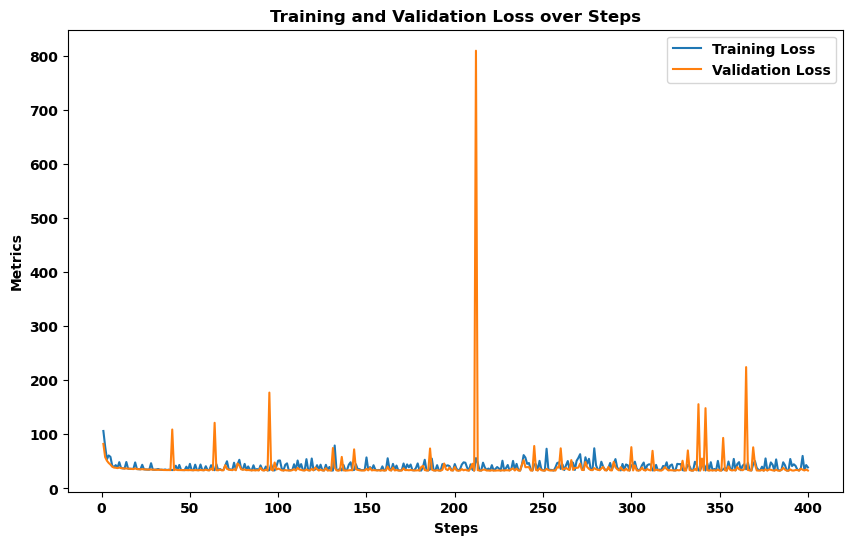

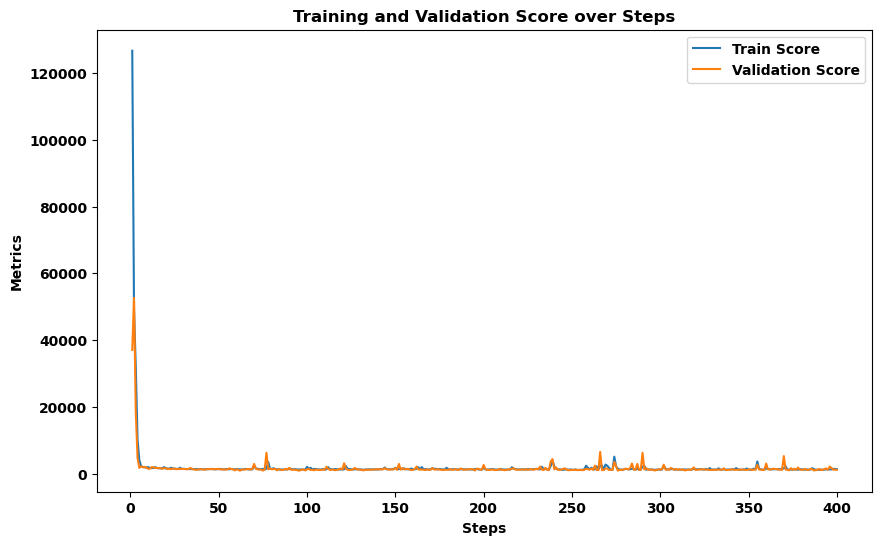

In [7]:
api = wandb.Api()

# Retrieve all runs
runs = api.runs(f"{entity}/{project_name}")

# Sort by end time (stop time) and filter only completed runs
finished_runs = [run for run in runs if run.state == "finished"]

if not finished_runs:
    print("❌ No completed run found!")
else:
    last_run = sorted(finished_runs, key=lambda r: r.created_at, reverse=True)[0]
    print("✔️ Last completed run:", last_run.id)

    run = api.run(f"{entity}/{project_name}/{last_run.id}")

history = run.history()

train_loss = history["epoch/train-loss"]
val_loss = history["epoch/val-loss"]
train_score = history["epoch/train-score"]
val_score = history["epoch/val-score"]

steps = range(len(history["_step"].values))

plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss")
plt.plot(steps, val_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steps, train_score, label="Train Score")
plt.plot(steps, val_score, label="Validation Score")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Score over Steps")
plt.legend()
plt.show()

Testing of group 1 (DF1 and DF3)

In [36]:
model.load_state_dict(torch.load(os.path.join(save_path, f'{config["model"]}_best.pth')))
model = model.to(device)

ds_test = CMAPSSDataset(mode='test', data_path=data_path, subset=config["dataset"])
test_rmse_13, test_score_13, all_predictions_13, ground_truth_13 = test_model(model, ds_test, batch_size=config["batch_size"], device='cuda')

# Save predictions
model_results["PINN_13"] = {
    "predictions": all_predictions_13.squeeze(1).detach().numpy(),
    "labels": ground_truth_13.squeeze(1).detach().numpy(),
    "rmse": test_rmse_13,
    "score": test_score_13   
}

Found 200 unique motor IDs in the data set.
(200, 16)


Testing: 100%|██████████| 2/2 [00:00<00:00, 47.69it/s]

Test RMSE: 17.9731, Test Score: 1309.9078


## Group 2

In [37]:
config = {
    "learning_rate": 1e-3,
    "num_epochs": 400,
    "batch_size": 128,
    "derivatives_order": 2,
    "hidden_dim": 3,
    "loss_lambda": 100,
    "dataset": "24",
    "model": "PINN_24"
}

Load data from group 2 (DF2 and DF4)

In [10]:
ds_train = CMAPSSDataset(mode='train', data_path=data_path, subset=config["dataset"], max_rul=125)

total_size = len(ds_train)

val_size = int(0.2 * total_size)  # 20% für Validierung
train_size = total_size - val_size  # Rest für Training
train_ds, val_ds = random_split(ds_train, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False, num_workers=0)

# Warm up (can take a while!)
for batch in train_loader:
    print(batch[2].shape)
    print("Warmed up")
    break

Found 509 unique motor IDs in the data set.
(115008, 16)
torch.Size([128])
Warmed up


In [38]:
model = PINN(input_dim=14, hidden_dim=config["hidden_dim"], derivatives_order=config["derivatives_order"]).to(device)
optimizer = Adan(model.parameters(), lr=config["learning_rate"])
criterion = AdaptivePhysicsBasedLoss(loss_lambda=config["loss_lambda"])
summary(model)

Layer (type:depth-idx)                                  Param #
PINN                                                    --
├─xNN: 1-1                                              --
│    └─MultiheadAttention: 2-1                          630
│    │    └─NonDynamicallyQuantizableLinear: 3-1        210
│    └─Linear: 2-2                                      210
│    └─Linear: 2-3                                      45
│    └─LayerNorm: 2-4                                   28
│    └─ReLU: 2-5                                        --
├─MLP: 1-2                                              6
│    └─Sequential: 2-6                                  --
│    │    └─Linear: 3-2                                 50
│    │    └─Tanh: 3-3                                   --
│    │    └─Linear: 3-4                                 110
│    │    └─Tanh: 3-5                                   --
│    │    └─Linear: 3-6                                 110
│    │    └─Tanh: 3-7                          

In [12]:
run = wandb.init(
    project=project_name,
    name=f'PINN_{config["dataset"]}',
    config = config
)

Training of group 2 (DF2 and DF4)

In [13]:
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, config)
trainer.fit()
torch.save(model.state_dict(), os.path.join(save_path, f'{run.config["model"]}_best.pth'))
run.finish()

Epoch 1/400


Validation Epoch 1: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 2/400


Validation Epoch 2: 100%|██████████| 180/180 [00:26<00:00,  6.92it/s]


Epoch 3/400


Validation Epoch 3: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 4/400


Validation Epoch 4: 100%|██████████| 180/180 [00:25<00:00,  6.93it/s]


Epoch 5/400


Validation Epoch 5: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 6/400


Validation Epoch 6: 100%|██████████| 180/180 [00:26<00:00,  6.69it/s]


Epoch 7/400


Validation Epoch 7: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 8/400


Validation Epoch 8: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 9/400


Validation Epoch 9: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 10/400


Validation Epoch 10: 100%|██████████| 180/180 [00:25<00:00,  7.11it/s]


Epoch 11/400


Validation Epoch 11: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 12/400


Validation Epoch 12: 100%|██████████| 180/180 [00:25<00:00,  6.95it/s]


Epoch 13/400


Validation Epoch 13: 100%|██████████| 180/180 [00:26<00:00,  6.90it/s]


Epoch 14/400


Validation Epoch 14: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 15/400


Validation Epoch 15: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 16/400


Validation Epoch 16: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 17/400


Validation Epoch 17: 100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


Epoch 18/400


Validation Epoch 18: 100%|██████████| 180/180 [00:26<00:00,  6.92it/s]


Epoch 19/400


Validation Epoch 19: 100%|██████████| 180/180 [00:26<00:00,  6.71it/s]


Epoch 20/400


Validation Epoch 20: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 21/400


Validation Epoch 21: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 22/400


Validation Epoch 22: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 23/400


Validation Epoch 23: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 24/400


Validation Epoch 24: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 25/400


Validation Epoch 25: 100%|██████████| 180/180 [00:25<00:00,  7.01it/s]


Epoch 26/400


Validation Epoch 26: 100%|██████████| 180/180 [00:25<00:00,  7.07it/s]


Epoch 27/400


Validation Epoch 27: 100%|██████████| 180/180 [00:25<00:00,  7.09it/s]


Epoch 28/400


Validation Epoch 28: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 29/400


Validation Epoch 29: 100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


Epoch 30/400


Validation Epoch 30: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 31/400


Validation Epoch 31: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 32/400


Validation Epoch 32: 100%|██████████| 180/180 [00:25<00:00,  7.14it/s]


Epoch 33/400


Validation Epoch 33: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 34/400


Validation Epoch 34: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 35/400


Validation Epoch 35: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 36/400


Validation Epoch 36: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 37/400


Validation Epoch 37: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 38/400


Validation Epoch 38: 100%|██████████| 180/180 [00:27<00:00,  6.66it/s]


Epoch 39/400


Validation Epoch 39: 100%|██████████| 180/180 [00:26<00:00,  6.68it/s]


Epoch 40/400


Validation Epoch 40: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 41/400


Validation Epoch 41: 100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


Epoch 42/400


Validation Epoch 42: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 43/400


Validation Epoch 43: 100%|██████████| 180/180 [00:25<00:00,  6.93it/s]


Epoch 44/400


Validation Epoch 44: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 45/400


Validation Epoch 45: 100%|██████████| 180/180 [00:25<00:00,  6.93it/s]


Epoch 46/400


Validation Epoch 46: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 47/400


Validation Epoch 47: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 48/400


Validation Epoch 48: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 49/400


Validation Epoch 49: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 50/400


Validation Epoch 50: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 51/400


Validation Epoch 51: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 52/400


Validation Epoch 52: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 53/400


Validation Epoch 53: 100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


Epoch 54/400


Validation Epoch 54: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 55/400


Validation Epoch 55: 100%|██████████| 180/180 [00:25<00:00,  7.03it/s]


Epoch 56/400


Validation Epoch 56: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 57/400


Validation Epoch 57: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 58/400


Validation Epoch 58: 100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


Epoch 59/400


Validation Epoch 59: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 60/400


Validation Epoch 60: 100%|██████████| 180/180 [00:26<00:00,  6.92it/s]


Epoch 61/400


Validation Epoch 61: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 62/400


Validation Epoch 62: 100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


Epoch 63/400


Validation Epoch 63: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 64/400


Validation Epoch 64: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 65/400


Validation Epoch 65: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 66/400


Validation Epoch 66: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 67/400


Validation Epoch 67: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 68/400


Validation Epoch 68: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 69/400


Validation Epoch 69: 100%|██████████| 180/180 [00:26<00:00,  6.72it/s]


Epoch 70/400


Validation Epoch 70: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 71/400


Validation Epoch 71: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 72/400


Validation Epoch 72: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 73/400


Validation Epoch 73: 100%|██████████| 180/180 [00:25<00:00,  7.11it/s]


Epoch 74/400


Validation Epoch 74: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 75/400


Validation Epoch 75: 100%|██████████| 180/180 [00:26<00:00,  6.90it/s]


Epoch 76/400


Validation Epoch 76: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 77/400


Validation Epoch 77: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 78/400


Validation Epoch 78: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 79/400


Validation Epoch 79: 100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


Epoch 80/400


Validation Epoch 80: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 81/400


Validation Epoch 81: 100%|██████████| 180/180 [00:25<00:00,  7.12it/s]


Epoch 82/400


Validation Epoch 82: 100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


Epoch 83/400


Validation Epoch 83: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 84/400


Validation Epoch 84: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 85/400


Validation Epoch 85: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 86/400


Validation Epoch 86: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 87/400


Validation Epoch 87: 100%|██████████| 180/180 [00:25<00:00,  7.02it/s]


Epoch 88/400


Validation Epoch 88: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 89/400


Validation Epoch 89: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 90/400


Validation Epoch 90: 100%|██████████| 180/180 [00:26<00:00,  6.78it/s]


Epoch 91/400


Validation Epoch 91: 100%|██████████| 180/180 [00:26<00:00,  6.69it/s]


Epoch 92/400


Validation Epoch 92: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 93/400


Validation Epoch 93: 100%|██████████| 180/180 [00:25<00:00,  7.07it/s]


Epoch 94/400


Validation Epoch 94: 100%|██████████| 180/180 [00:25<00:00,  7.02it/s]


Epoch 95/400


Validation Epoch 95: 100%|██████████| 180/180 [00:25<00:00,  7.05it/s]


Epoch 96/400


Validation Epoch 96: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 97/400


Validation Epoch 97: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 98/400


Validation Epoch 98: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 99/400


Validation Epoch 99: 100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


Epoch 100/400


Validation Epoch 100: 100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


Epoch 101/400


Validation Epoch 101: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 102/400


Validation Epoch 102: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 103/400


Validation Epoch 103: 100%|██████████| 180/180 [00:25<00:00,  7.01it/s]


Epoch 104/400


Validation Epoch 104: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 105/400


Validation Epoch 105: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 106/400


Validation Epoch 106: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 107/400


Validation Epoch 107: 100%|██████████| 180/180 [00:26<00:00,  6.90it/s]


Epoch 108/400


Validation Epoch 108: 100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


Epoch 109/400


Validation Epoch 109: 100%|██████████| 180/180 [00:25<00:00,  7.05it/s]


Epoch 110/400


Validation Epoch 110: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 111/400


Validation Epoch 111: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 112/400


Validation Epoch 112: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 113/400


Validation Epoch 113: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 114/400


Validation Epoch 114: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 115/400


Validation Epoch 115: 100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


Epoch 116/400


Validation Epoch 116: 100%|██████████| 180/180 [00:25<00:00,  6.95it/s]


Epoch 117/400


Validation Epoch 117: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 118/400


Validation Epoch 118: 100%|██████████| 180/180 [00:26<00:00,  6.77it/s]


Epoch 119/400


Validation Epoch 119: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 120/400


Validation Epoch 120: 100%|██████████| 180/180 [00:26<00:00,  6.78it/s]


Epoch 121/400


Validation Epoch 121: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 122/400


Validation Epoch 122: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 123/400


Validation Epoch 123: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 124/400


Validation Epoch 124: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 125/400


Validation Epoch 125: 100%|██████████| 180/180 [00:26<00:00,  6.68it/s]


Epoch 126/400


Validation Epoch 126: 100%|██████████| 180/180 [00:25<00:00,  6.93it/s]


Epoch 127/400


Validation Epoch 127: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 128/400


Validation Epoch 128: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 129/400


Validation Epoch 129: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 130/400


Validation Epoch 130: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 131/400


Validation Epoch 131: 100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


Epoch 132/400


Validation Epoch 132: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 133/400


Validation Epoch 133: 100%|██████████| 180/180 [00:25<00:00,  7.02it/s]


Epoch 134/400


Validation Epoch 134: 100%|██████████| 180/180 [00:25<00:00,  7.06it/s]


Epoch 135/400


Validation Epoch 135: 100%|██████████| 180/180 [00:25<00:00,  6.93it/s]


Epoch 136/400


Validation Epoch 136: 100%|██████████| 180/180 [00:25<00:00,  7.04it/s]


Epoch 137/400


Validation Epoch 137: 100%|██████████| 180/180 [00:27<00:00,  6.62it/s]


Epoch 138/400


Validation Epoch 138: 100%|██████████| 180/180 [00:25<00:00,  7.03it/s]


Epoch 139/400


Validation Epoch 139: 100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


Epoch 140/400


Validation Epoch 140: 100%|██████████| 180/180 [00:27<00:00,  6.67it/s]


Epoch 141/400


Validation Epoch 141: 100%|██████████| 180/180 [00:26<00:00,  6.78it/s]


Epoch 142/400


Validation Epoch 142: 100%|██████████| 180/180 [00:26<00:00,  6.90it/s]


Epoch 143/400


Validation Epoch 143: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 144/400


Validation Epoch 144: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 145/400


Validation Epoch 145: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 146/400


Validation Epoch 146: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 147/400


Validation Epoch 147: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 148/400


Validation Epoch 148: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 149/400


Validation Epoch 149: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 150/400


Validation Epoch 150: 100%|██████████| 180/180 [00:24<00:00,  7.20it/s]


Epoch 151/400


Validation Epoch 151: 100%|██████████| 180/180 [00:25<00:00,  7.08it/s]


Epoch 152/400


Validation Epoch 152: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 153/400


Validation Epoch 153: 100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


Epoch 154/400


Validation Epoch 154: 100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


Epoch 155/400


Validation Epoch 155: 100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


Epoch 156/400


Validation Epoch 156: 100%|██████████| 180/180 [00:26<00:00,  6.77it/s]


Epoch 157/400


Validation Epoch 157: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 158/400


Validation Epoch 158: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 159/400


Validation Epoch 159: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 160/400


Validation Epoch 160: 100%|██████████| 180/180 [00:26<00:00,  6.69it/s]


Epoch 161/400


Validation Epoch 161: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 162/400


Validation Epoch 162: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 163/400


Validation Epoch 163: 100%|██████████| 180/180 [00:25<00:00,  7.06it/s]


Epoch 164/400


Validation Epoch 164: 100%|██████████| 180/180 [00:25<00:00,  6.95it/s]


Epoch 165/400


Validation Epoch 165: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 166/400


Validation Epoch 166: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 167/400


Validation Epoch 167: 100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


Epoch 168/400


Validation Epoch 168: 100%|██████████| 180/180 [00:25<00:00,  7.02it/s]


Epoch 169/400


Validation Epoch 169: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 170/400


Validation Epoch 170: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 171/400


Validation Epoch 171: 100%|██████████| 180/180 [00:26<00:00,  6.90it/s]


Epoch 172/400


Validation Epoch 172: 100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


Epoch 173/400


Validation Epoch 173: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 174/400


Validation Epoch 174: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 175/400


Validation Epoch 175: 100%|██████████| 180/180 [00:25<00:00,  6.93it/s]


Epoch 176/400


Validation Epoch 176: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 177/400


Validation Epoch 177: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 178/400


Validation Epoch 178: 100%|██████████| 180/180 [00:26<00:00,  6.67it/s]


Epoch 179/400


Validation Epoch 179: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 180/400


Validation Epoch 180: 100%|██████████| 180/180 [00:27<00:00,  6.63it/s]


Epoch 181/400


Validation Epoch 181: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 182/400


Validation Epoch 182: 100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


Epoch 183/400


Validation Epoch 183: 100%|██████████| 180/180 [00:26<00:00,  6.71it/s]


Epoch 184/400


Validation Epoch 184: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 185/400


Validation Epoch 185: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 186/400


Validation Epoch 186: 100%|██████████| 180/180 [00:26<00:00,  6.77it/s]


Epoch 187/400


Validation Epoch 187: 100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


Epoch 188/400


Validation Epoch 188: 100%|██████████| 180/180 [00:26<00:00,  6.78it/s]


Epoch 189/400


Validation Epoch 189: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 190/400


Validation Epoch 190: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 191/400


Validation Epoch 191: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 192/400


Validation Epoch 192: 100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


Epoch 193/400


Validation Epoch 193: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 194/400


Validation Epoch 194: 100%|██████████| 180/180 [00:26<00:00,  6.71it/s]


Epoch 195/400


Validation Epoch 195: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 196/400


Validation Epoch 196: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 197/400


Validation Epoch 197: 100%|██████████| 180/180 [00:25<00:00,  7.09it/s]


Epoch 198/400


Validation Epoch 198: 100%|██████████| 180/180 [00:26<00:00,  6.78it/s]


Epoch 199/400


Validation Epoch 199: 100%|██████████| 180/180 [00:25<00:00,  6.93it/s]


Epoch 200/400


Validation Epoch 200: 100%|██████████| 180/180 [00:26<00:00,  6.68it/s]


Epoch 201/400


Validation Epoch 201: 100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


Epoch 202/400


Validation Epoch 202: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 203/400


Validation Epoch 203: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 204/400


Validation Epoch 204: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 205/400


Validation Epoch 205: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 206/400


Validation Epoch 206: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 207/400


Validation Epoch 207: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 208/400


Validation Epoch 208: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 209/400


Validation Epoch 209: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 210/400


Validation Epoch 210: 100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


Epoch 211/400


Validation Epoch 211: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 212/400


Validation Epoch 212: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 213/400


Validation Epoch 213: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 214/400


Validation Epoch 214: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 215/400


Validation Epoch 215: 100%|██████████| 180/180 [00:26<00:00,  6.77it/s]


Epoch 216/400


Validation Epoch 216: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 217/400


Validation Epoch 217: 100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


Epoch 218/400


Validation Epoch 218: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 219/400


Validation Epoch 219: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 220/400


Validation Epoch 220: 100%|██████████| 180/180 [00:25<00:00,  7.01it/s]


Epoch 221/400


Validation Epoch 221: 100%|██████████| 180/180 [00:26<00:00,  6.75it/s]


Epoch 222/400


Validation Epoch 222: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 223/400


Validation Epoch 223: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 224/400


Validation Epoch 224: 100%|██████████| 180/180 [00:26<00:00,  6.77it/s]


Epoch 225/400


Validation Epoch 225: 100%|██████████| 180/180 [00:24<00:00,  7.29it/s]


Epoch 226/400


Validation Epoch 226: 100%|██████████| 180/180 [00:26<00:00,  6.67it/s]


Epoch 227/400


Validation Epoch 227: 100%|██████████| 180/180 [00:26<00:00,  6.71it/s]


Epoch 228/400


Validation Epoch 228: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 229/400


Validation Epoch 229: 100%|██████████| 180/180 [00:27<00:00,  6.59it/s]


Epoch 230/400


Validation Epoch 230: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 231/400


Validation Epoch 231: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 232/400


Validation Epoch 232: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 233/400


Validation Epoch 233: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 234/400


Validation Epoch 234: 100%|██████████| 180/180 [00:26<00:00,  6.69it/s]


Epoch 235/400


Validation Epoch 235: 100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


Epoch 236/400


Validation Epoch 236: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 237/400


Validation Epoch 237: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 238/400


Validation Epoch 238: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 239/400


Validation Epoch 239: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 240/400


Validation Epoch 240: 100%|██████████| 180/180 [00:26<00:00,  6.92it/s]


Epoch 241/400


Validation Epoch 241: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 242/400


Validation Epoch 242: 100%|██████████| 180/180 [00:26<00:00,  6.68it/s]


Epoch 243/400


Validation Epoch 243: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 244/400


Validation Epoch 244: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 245/400


Validation Epoch 245: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 246/400


Validation Epoch 246: 100%|██████████| 180/180 [00:27<00:00,  6.60it/s]


Epoch 247/400


Validation Epoch 247: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 248/400


Validation Epoch 248: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 249/400


Validation Epoch 249: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 250/400


Validation Epoch 250: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 251/400


Validation Epoch 251: 100%|██████████| 180/180 [00:26<00:00,  6.73it/s]


Epoch 252/400


Validation Epoch 252: 100%|██████████| 180/180 [00:26<00:00,  6.71it/s]


Epoch 253/400


Validation Epoch 253: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 254/400


Validation Epoch 254: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 255/400


Validation Epoch 255: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 256/400


Validation Epoch 256: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 257/400


Validation Epoch 257: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 258/400


Validation Epoch 258: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 259/400


Validation Epoch 259: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 260/400


Validation Epoch 260: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 261/400


Validation Epoch 261: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 262/400


Validation Epoch 262: 100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


Epoch 263/400


Validation Epoch 263: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 264/400


Validation Epoch 264: 100%|██████████| 180/180 [00:26<00:00,  6.77it/s]


Epoch 265/400


Validation Epoch 265: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 266/400


Validation Epoch 266: 100%|██████████| 180/180 [00:27<00:00,  6.66it/s]


Epoch 267/400


Validation Epoch 267: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 268/400


Validation Epoch 268: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 269/400


Validation Epoch 269: 100%|██████████| 180/180 [00:26<00:00,  6.92it/s]


Epoch 270/400


Validation Epoch 270: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 271/400


Validation Epoch 271: 100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


Epoch 272/400


Validation Epoch 272: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 273/400


Validation Epoch 273: 100%|██████████| 180/180 [00:26<00:00,  6.70it/s]


Epoch 274/400


Validation Epoch 274: 100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


Epoch 275/400


Validation Epoch 275: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 276/400


Validation Epoch 276: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 277/400


Validation Epoch 277: 100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


Epoch 278/400


Validation Epoch 278: 100%|██████████| 180/180 [00:26<00:00,  6.77it/s]


Epoch 279/400


Validation Epoch 279: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 280/400


Validation Epoch 280: 100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


Epoch 281/400


Validation Epoch 281: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 282/400


Validation Epoch 282: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 283/400


Validation Epoch 283: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 284/400


Validation Epoch 284: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 285/400


Validation Epoch 285: 100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


Epoch 286/400


Validation Epoch 286: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 287/400


Validation Epoch 287: 100%|██████████| 180/180 [00:26<00:00,  6.72it/s]


Epoch 288/400


Validation Epoch 288: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 289/400


Validation Epoch 289: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 290/400


Validation Epoch 290: 100%|██████████| 180/180 [00:25<00:00,  7.08it/s]


Epoch 291/400


Validation Epoch 291: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 292/400


Validation Epoch 292: 100%|██████████| 180/180 [00:27<00:00,  6.64it/s]


Epoch 293/400


Validation Epoch 293: 100%|██████████| 180/180 [00:26<00:00,  6.71it/s]


Epoch 294/400


Validation Epoch 294: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 295/400


Validation Epoch 295: 100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


Epoch 296/400


Validation Epoch 296: 100%|██████████| 180/180 [00:26<00:00,  6.77it/s]


Epoch 297/400


Validation Epoch 297: 100%|██████████| 180/180 [00:26<00:00,  6.92it/s]


Epoch 298/400


Validation Epoch 298: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 299/400


Validation Epoch 299: 100%|██████████| 180/180 [00:26<00:00,  6.68it/s]


Epoch 300/400


Validation Epoch 300: 100%|██████████| 180/180 [00:25<00:00,  7.02it/s]


Epoch 301/400


Validation Epoch 301: 100%|██████████| 180/180 [00:26<00:00,  6.92it/s]


Epoch 302/400


Validation Epoch 302: 100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


Epoch 303/400


Validation Epoch 303: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 304/400


Validation Epoch 304: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 305/400


Validation Epoch 305: 100%|██████████| 180/180 [00:26<00:00,  6.71it/s]


Epoch 306/400


Validation Epoch 306: 100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


Epoch 307/400


Validation Epoch 307: 100%|██████████| 180/180 [00:25<00:00,  7.11it/s]


Epoch 308/400


Validation Epoch 308: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 309/400


Validation Epoch 309: 100%|██████████| 180/180 [00:26<00:00,  6.90it/s]


Epoch 310/400


Validation Epoch 310: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 311/400


Validation Epoch 311: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 312/400


Validation Epoch 312: 100%|██████████| 180/180 [00:25<00:00,  6.93it/s]


Epoch 313/400


Validation Epoch 313: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 314/400


Validation Epoch 314: 100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


Epoch 315/400


Validation Epoch 315: 100%|██████████| 180/180 [00:24<00:00,  7.22it/s]


Epoch 316/400


Validation Epoch 316: 100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


Epoch 317/400


Validation Epoch 317: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 318/400


Validation Epoch 318: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 319/400


Validation Epoch 319: 100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


Epoch 320/400


Validation Epoch 320: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 321/400


Validation Epoch 321: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 322/400


Validation Epoch 322: 100%|██████████| 180/180 [00:26<00:00,  6.92it/s]


Epoch 323/400


Validation Epoch 323: 100%|██████████| 180/180 [00:26<00:00,  6.78it/s]


Epoch 324/400


Validation Epoch 324: 100%|██████████| 180/180 [00:25<00:00,  7.00it/s]


Epoch 325/400


Validation Epoch 325: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 326/400


Validation Epoch 326: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 327/400


Validation Epoch 327: 100%|██████████| 180/180 [00:25<00:00,  6.95it/s]


Epoch 328/400


Validation Epoch 328: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 329/400


Validation Epoch 329: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 330/400


Validation Epoch 330: 100%|██████████| 180/180 [00:26<00:00,  6.90it/s]


Epoch 331/400


Validation Epoch 331: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 332/400


Validation Epoch 332: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 333/400


Validation Epoch 333: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 334/400


Validation Epoch 334: 100%|██████████| 180/180 [00:26<00:00,  6.77it/s]


Epoch 335/400


Validation Epoch 335: 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


Epoch 336/400


Validation Epoch 336: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 337/400


Validation Epoch 337: 100%|██████████| 180/180 [00:26<00:00,  6.78it/s]


Epoch 338/400


Validation Epoch 338: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 339/400


Validation Epoch 339: 100%|██████████| 180/180 [00:25<00:00,  6.93it/s]


Epoch 340/400


Validation Epoch 340: 100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


Epoch 341/400


Validation Epoch 341: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 342/400


Validation Epoch 342: 100%|██████████| 180/180 [00:26<00:00,  6.90it/s]


Epoch 343/400


Validation Epoch 343: 100%|██████████| 180/180 [00:27<00:00,  6.65it/s]


Epoch 344/400


Validation Epoch 344: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 345/400


Validation Epoch 345: 100%|██████████| 180/180 [00:26<00:00,  6.77it/s]


Epoch 346/400


Validation Epoch 346: 100%|██████████| 180/180 [00:25<00:00,  7.03it/s]


Epoch 347/400


Validation Epoch 347: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 348/400


Validation Epoch 348: 100%|██████████| 180/180 [00:26<00:00,  6.69it/s]


Epoch 349/400


Validation Epoch 349: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 350/400


Validation Epoch 350: 100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


Epoch 351/400


Validation Epoch 351: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Epoch 352/400


Validation Epoch 352: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 353/400


Validation Epoch 353: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 354/400


Validation Epoch 354: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 355/400


Validation Epoch 355: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 356/400


Validation Epoch 356: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 357/400


Validation Epoch 357: 100%|██████████| 180/180 [00:25<00:00,  7.16it/s]


Epoch 358/400


Validation Epoch 358: 100%|██████████| 180/180 [00:25<00:00,  7.06it/s]


Epoch 359/400


Validation Epoch 359: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 360/400


Validation Epoch 360: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 361/400


Validation Epoch 361: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 362/400


Validation Epoch 362: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 363/400


Validation Epoch 363: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 364/400


Validation Epoch 364: 100%|██████████| 180/180 [00:26<00:00,  6.90it/s]


Epoch 365/400


Validation Epoch 365: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 366/400


Validation Epoch 366: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 367/400


Validation Epoch 367: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 368/400


Validation Epoch 368: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 369/400


Validation Epoch 369: 100%|██████████| 180/180 [00:25<00:00,  6.98it/s]


Epoch 370/400


Validation Epoch 370: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 371/400


Validation Epoch 371: 100%|██████████| 180/180 [00:25<00:00,  7.02it/s]


Epoch 372/400


Validation Epoch 372: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 373/400


Validation Epoch 373: 100%|██████████| 180/180 [00:25<00:00,  7.01it/s]


Epoch 374/400


Validation Epoch 374: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 375/400


Validation Epoch 375: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 376/400


Validation Epoch 376: 100%|██████████| 180/180 [00:26<00:00,  6.88it/s]


Epoch 377/400


Validation Epoch 377: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 378/400


Validation Epoch 378: 100%|██████████| 180/180 [00:26<00:00,  6.92it/s]


Epoch 379/400


Validation Epoch 379: 100%|██████████| 180/180 [00:26<00:00,  6.90it/s]


Epoch 380/400


Validation Epoch 380: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 381/400


Validation Epoch 381: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 382/400


Validation Epoch 382: 100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


Epoch 383/400


Validation Epoch 383: 100%|██████████| 180/180 [00:26<00:00,  6.68it/s]


Epoch 384/400


Validation Epoch 384: 100%|██████████| 180/180 [00:25<00:00,  7.07it/s]


Epoch 385/400


Validation Epoch 385: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 386/400


Validation Epoch 386: 100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


Epoch 387/400


Validation Epoch 387: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


Epoch 388/400


Validation Epoch 388: 100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


Epoch 389/400


Validation Epoch 389: 100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


Epoch 390/400


Validation Epoch 390: 100%|██████████| 180/180 [00:26<00:00,  6.72it/s]


Epoch 391/400


Validation Epoch 391: 100%|██████████| 180/180 [00:26<00:00,  6.76it/s]


Epoch 392/400


Validation Epoch 392: 100%|██████████| 180/180 [00:26<00:00,  6.89it/s]


Epoch 393/400


Validation Epoch 393: 100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


Epoch 394/400


Validation Epoch 394: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 395/400


Validation Epoch 395: 100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


Epoch 396/400


Validation Epoch 396: 100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


Epoch 397/400


Validation Epoch 397: 100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


Epoch 398/400


Validation Epoch 398: 100%|██████████| 180/180 [00:25<00:00,  7.00it/s]


Epoch 399/400


Validation Epoch 399: 100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


Epoch 400/400


Validation Epoch 400: 100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
epoch/train-data-loss,▄▂▃▃▇▅▃█▂▂▃▃▂▃▂▅▃▃▃▅▁▂▄▂▃█▄▃▁▁▅▂▅▃▄▂▁▅▃▄
epoch/train-loss,█▅▄▃▂▂▃▂▃▂▃▂▁▃▂▂▂▃▁▃▄▄▂▂▃▃▁▃▁▃▂▂▃▁▂▃▂▂▃▄
epoch/train-physics-loss,█▂▂▂▃▂▁▂▃▂▂▂▂▂▁▂▁▂▁▂▁▂▁▂▂▂▁▂▂▂▂▂▂▂▁▂▂▃▁▁
epoch/train-score,█▆▅▄▂▁▂▁▁▁▃▃▁▁▁▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▂
epoch/val-data-loss,▄▆▁▃▇▁▂▁▂█▁▃▁▁▁▁▂▁▂▁▁▁▁▁▁▂▇▃▁▂▃▅▂▃▁▁▆▁▁▆
epoch/val-loss,▂▂▁▁▂▁▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▂█▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁
epoch/val-physics-loss,█▆▇▂▄▁▃▃▃▂▂▄▂▃▃▃▂▂▃▂▃▃▃▃▃▆▃▃▁▂▄▄▃▃▂▃▂▄▃▄
epoch/val-score,█▂▂▁▁▁▁▁▁▁▁▁▁▅▁▁▁▂▁▃▁▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train/data-loss,█▇▃█▆▃▃▃▂▅▂▂▃▁▄▃▅▃▇▄▃▃▃▅▂▃▂▄▁▆▃▃▅▃▅▃▄▂▆▃
train/loss,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


✔️ Last completed run: e48e4hh4


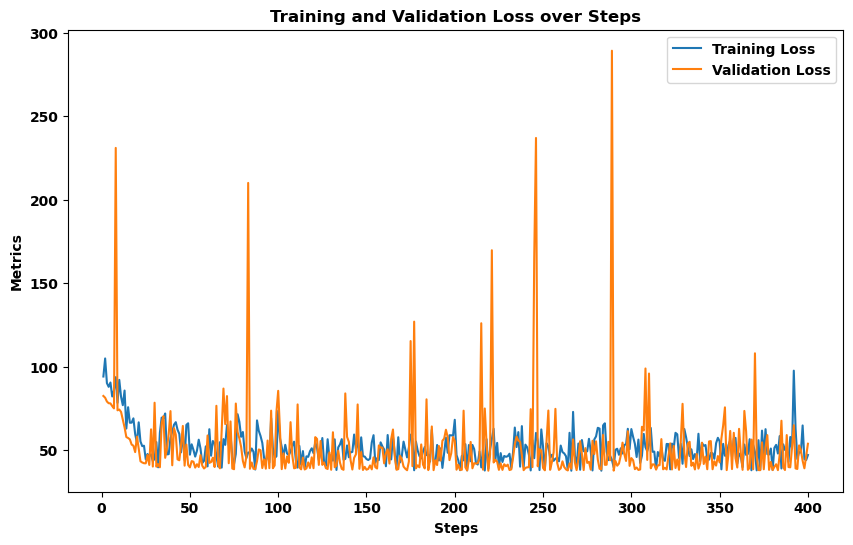

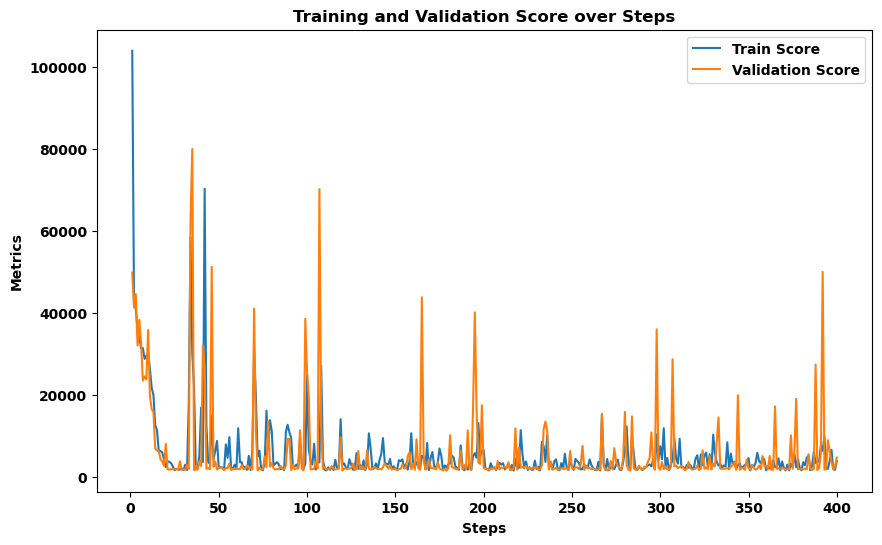

In [14]:
api = wandb.Api()

# Retrieve all runs
runs = api.runs(f"{entity}/{project_name}")

# Sort by end time (stop time) and filter only completed runs
finished_runs = [run for run in runs if run.state == "finished"]

if not finished_runs:
    print("❌ No completed run found!")
else:
    last_run = sorted(finished_runs, key=lambda r: r.created_at, reverse=True)[0]
    print("✔️ Last completed run:", last_run.id)

    run = api.run(f"{entity}/{project_name}/{last_run.id}")

history = run.history()

train_loss = history["epoch/train-loss"]
val_loss = history["epoch/val-loss"]
train_score = history["epoch/train-score"]
val_score = history["epoch/val-score"]

steps = range(len(history["_step"].values))

plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss")
plt.plot(steps, val_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steps, train_score, label="Train Score")
plt.plot(steps, val_score, label="Validation Score")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Score over Steps")
plt.legend()
plt.show()

Testing of group 2 (DF2 and DF4)

In [39]:
model.load_state_dict(torch.load(os.path.join(save_path, f'{config["model"]}_best.pth')))
model = model.to(device)

ds_test = CMAPSSDataset(mode='test', data_path=data_path, subset=config["dataset"])
test_rmse_24, test_score_24, all_predictions_24, ground_truth_24 = test_model(model, ds_test, batch_size=config["batch_size"], device='cuda')

# Save predictions
model_results["PINN_24"] = {
    "predictions": all_predictions_24.squeeze(1).detach().numpy(),
    "labels": ground_truth_24.squeeze(1).detach().numpy(),
    "rmse": test_rmse_24,
    "score": test_score_24   
}

Found 507 unique motor IDs in the data set.
(507, 16)


Testing: 100%|██████████| 4/4 [00:00<00:00, 38.21it/s]

Test RMSE: 28.8670, Test Score: 8656.1512


## Overall Test

In [42]:
import pandas as pd
from sklearn.metrics import f1_score, mean_squared_error

rul_score = Score.compute_score

load_path = os.path.join(data_path, 'ids.txt')
arrays = {}
current_key = None

with open(load_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith("id"):
            current_key = line.replace(":", "")
            arrays[current_key] = []
        elif current_key and line:
            arrays[current_key].extend(map(int, line.split()))

# Konvertieren in NumPy-Arrays
id_train_13 = np.array(arrays["id_train13"])
id_train_24 = np.array(arrays["id_train24"])
id_test_13 = np.array(arrays["id_test13"])
id_test_24 = np.array(arrays["id_test24"])

print("Array1:", id_train_13.shape)
print("Array2:", id_train_24.shape)
print("Array3:", id_test_13.shape)
print("Array4:", id_test_24.shape)


def merge_pred_id(ids, predictions):
    if len(ids) != len(predictions):
        raise ValueError("IDs und Predictions müssen die gleiche Länge haben.")

    combined = np.column_stack((ids, predictions))
    return combined

print(f'Pred13: {len(all_predictions_13)} -- IDs13: {len(id_test_13)}')
print(f'Pred24: {len(all_predictions_24)} -- IDs13: {len(id_test_24)}')

predictions13 = merge_pred_id(id_test_13, all_predictions_13.detach().numpy())
predictions24 = merge_pred_id(id_test_24, all_predictions_24.detach().numpy())

combined = np.vstack((predictions13, predictions24))
predicted_rul = combined[np.argsort(combined[:, 0])]
rul_true = rul = np.loadtxt(os.path.join(data_path, 'RUL_test.txt'), dtype=np.float32)
rul_true = np.minimum(rul_true, 125)

rmse = np.sqrt(mean_squared_error(rul_true, predicted_rul[:,1]))
print(f'RMSE: {rmse:.1f}')

score = rul_score(torch.tensor(rul_true), torch.tensor(predicted_rul[:,1]))
print(f'RUL-Score: {score:.0f}')

predicted_labels = predicted_rul.copy()
predicted_labels[:,1] = (predicted_rul[:,1] <= 100).astype(int)
true_labels = (rul_true <= 100).astype(int)

F1_score = f1_score(true_labels, predicted_labels[:,1])
print(f'F1 Score: {F1_score:.3f}')

df_result = pd.DataFrame(predicted_labels, columns=['engine_no', 'result'], dtype=int)
display(df_result)
model_name = 'PINN'
# Speichern als CSV-Datei
csv_file_path = os.path.join(result_path, f'results_{model_name}.csv')
df_result.to_csv(csv_file_path, index=False)

# Save predictions
model_results["PINN"] = {
    "predictions": predicted_rul[:,1],
    "labels": rul_true,
    "rmse": rmse,
    "score": score,
    "f1_score": F1_score
}

Array1: (200,)
Array2: (509,)
Array3: (200,)
Array4: (507,)
Pred13: 200 -- IDs13: 200
Pred24: 507 -- IDs13: 507
RMSE: 26.3
RUL-Score: 19739
F1 Score: 0.830


,engine_no,result
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
702,702,0
703,703,1
704,704,1
705,705,1


In [43]:
file_path = os.path.join(result_path, "PINN_predictions.npz")
np.savez(file_path, model_results=model_results)